**Module:** CS5014 - Data Science

**Student Name:** Tony Clarke

**Student Number:** 18205607

## E-tivity   - Binary Logistic regression - Task A
There are many situations where some $y$ should be a noisy
representation of some function of $x_1,\ldots,x_p$, but the 
response outcomes $y$ are binary.

Binary logistic regression corresponds to this probabilistic model

$$
p\left(y|w^T x \right)=\phi(w^T x)^{y}(1-\phi(w^T x ))^{1-y}  \text{ for } y=0,1
$$

where $w \in \mathbb{R}^p$ is the vector if coefficient and $\phi(\cdot)$ is some sigmoid function,e.g.,

* Logistic function: $\phi(x)=1/(1+e^{-x})$
* probit function: $\phi(x)=0.5(1+\text{erf}(x/\sqrt{2}))$


Given $N$ training data, the likelihood function assuming that all the observations in the sample are independently Bernoulli distributed is

$$
{\displaystyle {\begin{aligned}L(\theta \mid x)&=\Pr(Y\mid X;\theta )\\&=\prod_{i=1}^Np(y_{i}\mid x_{i};\theta )\\&=\prod _{i=1}^N\phi(w^T x_{i})^{y_{i}}(1-\phi(w^T x_{i}))^{(1-y_{i})}\end{aligned}}}
$$

Our goal is to find the maximum likelihood estimate of the vector of the parameters $w$, that is to solve the optimisation problem

$$
\hat{w} =\arg\max_{w \in \mathbb{R}^p} \prod _{i=1}^N\phi(w^T x_{i})^{y_{i}}(1-\phi(w^T x_{i}))^{(1-y_{i})}
$$

The product of probability (that are numbers between $0$ and $1$) can become very small for large $N$
and can lead to arithmetic underflow problems.
To avoid this problem, one typically maximises the logarithm of the likelihood function (log transform). In fact, one can prove that for any nonnegative function

$$
\arg\max_{x} f(x) = \arg\max_{x} \log(x)  
$$

and, therefore, we actually solve:

$$
\hat{w} =\arg\max_{w \in \mathbb{R}^p}  \sum _{i=1}^{N}y_{i}\log(\phi(w^T x_{i}))+(1-y_{i})\log(1-\phi(w^T x_{i}))
 $$

which is maximized using optimization techniques.

**Reguralisation**
In general-recipe ML, reguralisation is used to reduce the problem of overfitting. 
Therefore, actually the problem we aim to solve is

$$
\hat{w} =\arg\max_{w \in \mathbb{R}^p}  \sum _{i=1}^{N}y_{i}\log(\phi(w^T x_{i}))+(1-y_{i})\log(1-\phi(w^T x_{i})) + \alpha||w||_2^2
 $$
 
 where $ \alpha$ is the reguralisation constant (a design parameter that is usually selected via cross-validation, note that $ \alpha\geq0$) and $||w||_2^2=\sum_{=1}^{p} w_i^2$. 


We assume that you know how logistic regression works: (i) how to compute the predicted probability; (ii) how to return the predicted class.


## Task A
Part 1 Theorethical questions: 

    What type of optimisation problem is it?
    1. Is it univariate or multivariate?
    2. Is it linear or nonlinear?
    3. Is it convex or not? (google it and cite your font, how is the fast way to prove it?)
    4. Is it constrained?

# Task A Answers

    1. multivariate
    2. linear
    3. It is logistic regression cost function is a convex problem. 
        The quickest method to prove this it is convex is to verify that the second 
        derivative is positive. 
    http://mathgotchas.blogspot.com/2011/10/why-is-error-function-minimized-in.html
    4. No the vector $w$ can take any value and is not constraint, however 
    constraints on the order of the weights would limit the search 
    to a region of the weight space.


## Task A
    
Part 2: The goal of this part is to reimplement **totally** from scratch the class LogisticRegression, that mimics the corresponding class in `Sklearn`. 
* The class must be flexible: the user can choose any type of differentiable (w.r.t. the parameters $w$) sigmoid function and the class must work for any number of features $p$ (suggestion: use `autograd` library). 
* As optimizer you should use `local_descent` with  `line_research`, see the Webinar 1 notebook.


You can implement the class either in Python or in Julia.



**Submission (README):** you must submit a Python notebook in Sulis. The notebook must only include the source code of the implemented class and optimization algorithm, and a short example about how to use it (e.g., how to run your code on the iris dataset, see the example below) so your peers can understand how to run your code. You must **not** include any tests you performed to verify that your code is properly working.

**Please use the following filename `TaskA_Yourfullname.ipynb` (or a zip file) and add your full name and student number at the top of your submitted notebook.**


In [1]:
from autograd.scipy.special import erf
import autograd.numpy as np
from autograd import grad
from math import sqrt

In [2]:
# Initial Bracket function - taken from Week1_Bracketing_LocalDescent.ipynb

def bracket_minimum(f, x=0, s=1e-2, k=2.0): #From the Book, pag.36
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    if yb > ya:
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    while True:
        c, yc = b + s, f(b + s)
        if yc > yb:
            return (a, c) if a<c else (c, a)        
        a, ya, b, yb = b, yb, c, yc
        s *= k

In [3]:
# Golden Search method - taken from Week1_Bracketing_LocalDescent.ipynb

ϕ = (1 + sqrt(5))/2

def golden_section_search(f, a, b, max_iter, plotting=True): #from the Book pag.41
    a0 =a
    b0=b
    ρ = φ-1
    d = ρ * b + (1 - ρ)*a
    yd = f(d)
    for i in range(max_iter-1):
        c = ρ*a + (1 - ρ)*b
        yc = f(c)
        if yc < yd:
            b, d, yd = d, c, yc
        else:
            a, b = b, c   
        if plotting==True:
            plt.figure()
            xx = np.linspace(a0,b0,100)
            plt.plot(xx,f(xx))
            plt.scatter(np.array([a,b]),np.array([a,b])*0)
            plt.scatter(np.array([a,b]),np.array([f(a),f(b)]))

    return (a, b) if a<b else (b, a)

In [4]:
# Line Search method - taken from Week1_Bracketing_LocalDescent.ipynb

def line_search(f, x, d, ϵ_x=0.0001, ϵ_d=0.0001):
    term = False
    if np.linalg.norm(d) < ϵ_d:
        print("Gradient norm below threshold")
        term = True
        return x
    objective = lambda α : f(x + α*d)
    a, b = bracket_minimum(objective)
    a, b  = golden_section_search(objective, a, b, max_iter = 5, plotting=False)
    α = (a+b)/2
    if np.linalg.norm(x+a*d-x)<ϵ_x:
        print("Step Tolerance below threshold")
        term = True
    return x + α*d, term


In [5]:
# Local Descent method - taken from Week1_Bracketing_LocalDescent.ipynb

def local_descent(β,cost, gradient,steps=10, α=None, ϵ_x=0.0001, ϵ_d=0.0001,  plotting=False):
    Tmp = [β]
    for iteration in range(steps):
        #print('In local_descent, iteration {}'.format(iteration))
        d = gradient(β)
        d = -d/np.linalg.norm(d) 
        #print(β,d)
        β, term = line_search(cost, β, d, ϵ_x=ϵ_x, ϵ_d=ϵ_d)
        if term == True:
            break
        Tmp.append(β)
    return Tmp

In [6]:
Optimimparam = {
    'α':0.001 ,
    'steps':10,
    'ϵ_x':0.0001,
    'ϵ_d':0.0001
}

In [7]:
#Skeleton code
class Generic_LogisticRegression():
    def __init__(self, θ, sigmoid, α=0.001):
        self.θ = θ #initial value of the parameter
        self.sigmoid = sigmoid #a sigmoid function that squezes the input into [0,1]
        self.α = α #reguralisation parameter
        self.cost_agg = []
     
    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {"θ": self.θ, "sigmoid": self.sigmoid, "α": self.α}
    
    def __agg_cost(self, cost):
        '''
        Helper function to aggregate the cost over training
        '''

        if (type(cost) is not np.numpy_boxes.ArrayBox):
            self.cost_agg.append(cost)
        
    def fit(self,X,y,optimization_method,Optimparam):    
        ##fit your model
        #cost function
        def loss(x,y,θ,sigmoid=self.sigmoid):
            α = self.α
            loss = y*(-1)*np.log((sigmoid(np.dot(x,θ)))) + (1-y)*(-1)*np.log(1-sigmoid(np.dot(x,θ))) + α*np.sum(np.square(θ))
            return loss
        
        def cost(θ):
            # MOB - Reorganised the cost function so I could aggregate the cost
            # Used in analysis to plot the cost over time
            
            cost = np.sum(loss(X,y,θ))
            self.__agg_cost(cost)
            
            return cost
        
        #automatic diff gradient function
        gradcost = grad(cost)

        #call the optimizer
        θ = optimization_method(self.θ, cost, gradcost, steps=Optimparam['steps'], α=Optimparam['α'], ϵ_x =  Optimparam['ϵ_x'], ϵ_d =  Optimparam['ϵ_d'], plotting=False)
        self.θ = θ[-1]
    
    
    def predict_proba(self, X):
        #predict probability of the class
        prob = []
        for x in X:
            prob.append(self.sigmoid(np.dot(x, self.θ)))
        return np.array(prob)  
        
    def predict(self, X):
        pred = []
        for x in X:
            pred.append(np.round(self.sigmoid(np.dot(x, self.θ))))
        return np.array(pred).astype(int)
    
# Mark's Prob Implementation
#     def __prob(self, x, theta):
#         '''
#         Helper that uses sigmoid fucntion to squash the result between zero and one
#         '''
#         return self.sigmoid(np.dot(x, theta))
    
#     def predict_proba(self, x):
#         return self.__prob(X, self.θ)
    
#     def predict(self, x):
#         return np.where(self.predict_proba(X) >= 0.5, 1, 0) 
        
#your implementation of the optimization algorithm
def minimize(args):
    return 0

# Data

In [8]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
X, y = load_iris(return_X_y=True)
ind = np.where((y==1) | (y==2))[0] # we only have two classes now
X = X[ind,:]
y = y[ind]

# add bias as per forum comments - this took a long time to figure out!
y = y.reshape((100,-1))
y = y - 1 

In [9]:
from math import e

θ = np.random.rand(X.shape[1])
def logistic(x):
    return 1 / (1 + e**(-x))

In [10]:
clf = LogisticRegression(random_state=0).fit(X, y)
clf.predict(X[:2, :])
clf.predict_proba(X[:2, :])
clf.score(X, y)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.97

## Mark O'Brien - Testing

In [11]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [12]:
class Validate_Model():
    
    def __init__(self, model, X, y, func, params):
        self.model = model
        self.X = X
        self.y = y
        self.func = func
        self.params = params
        self.y_pred = None
    
    def fit(self):
        self.model.fit(self.X, self.y, self.func, self.params)
        self.y_pred = self.model.predict(self.X)
        
    def log_loss(self):
        loss = metrics.log_loss(self.y, self.y_pred)
        return loss
    
    def accuracy(self):
        acc = metrics.accuracy_score(self.y, self.y_pred)
        clf = LogisticRegression(random_state=0, solver='liblinear').fit(self.X, self.y)
        skl = clf.score(self.X, self.y)
        return f'Accuracy {acc} compared to Sklearn {skl}'
    
    def confusion_matrix(self):
        cnf_matrix = metrics.confusion_matrix(self.y, self.y_pred)
        return cnf_matrix
        
    def training_loss(self):
        cost_agg = self.model.cost_agg
        plt.plot(cost_agg)
        plt.title('Training Cost Over Time')
        plt.show()
        
    def cross_validate(self):
        acc_agg = []
        skfold = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
        for train_index, test_index in skfold.split(self.X, self.y):

            X_train, X_test = self.X[train_index], self.X[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]

            GLR = Generic_LogisticRegression(θ, logistic)
            GLR.fit(self.X, self.y, self.func, self.params)
            y_pred = GLR.predict(X_train)

            acc = metrics.accuracy_score(y_train, y_pred)
            acc_agg.append(acc)
            
        avg = np.mean(acc_agg)
        return f'All values: {acc_agg} with average of {avg}'

In [13]:
GLR = Generic_LogisticRegression(θ, logistic)
m_val = Validate_Model(GLR, X, y, local_descent, Optimimparam)
m_val.fit()

The algorithms output for log loss is 13.470282713501206
Accuracy 0.61 compared to Sklearn 0.97
Confusion Matrix Values
[[30 20]
 [19 31]]


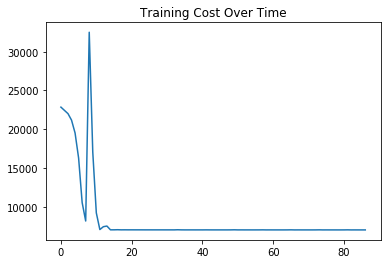

Using Stratified KFold Cross Validation
All values: [0.6125, 0.625, 0.5875, 0.5875, 0.6375] with average of 0.61


In [14]:
# Log Loss
print(f'The algorithms output for log loss is {m_val.log_loss()}')

# Accuracy
print(m_val.accuracy())

# Confusion Matrix
print('Confusion Matrix Values')
print(m_val.confusion_matrix())

# Plotting the loss over training time
m_val.training_loss()

print('Using Stratified KFold Cross Validation')
print(m_val.cross_validate())

### Evaluation Summary
To evaluate this model I used a the following methods:

#### Accuracy
Accuracy is simply the number of correct predictions that our classifier made measured as a percentage. I chose to output the Sklearn accuracy in order to compare. 

This algorithm scored varying accuracies at different run ranging from 60% up to 85%. The log loss may give an indication of the size of penalty being applied to incorrect classification. 

#### Log Loss 
Log loss imposes a heavy penalty on classifiers that are confidant about an incorrect classification. If the classifier does a good job of predicting the correct class then it will receive a low log loss score. The closer to zero the better our classifier has performed in true positive predictions. 

The score for this classifier was 13.4 at this run. Looking at the confusion matrix next this metric makes more sense. 

#### Confusion Matrix
The confusion matrix is a measure of how many True-Positives, True-Negatives, False-Positives & False-Negatives that the classifier has predicted. 

In this case we can see that the classifier output 20 False-Positives and 19 False-Negatives. This shows how we didn't have a near zero value for log loss. 


#### Plot of Cost Over Time
With this plot we would expect to see a decline in cost of the total training time for the classifier. The plot shows that there was some severe changes in cost before abruptly converging.

#### Cross Validation
The purpose of using cross validation as an evaluation metric is to determine if the predicted accuracy of the classifier is consistent. 

In this case there was some slight deviation with a range of 58% to 63% with an average of 61% which matches the accuracy measured earlier. 